In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import tqdm
from tqdm.notebook import tqdm as notebooktqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import timm
from timm.layers import BatchNormAct2d
import os
# from google.colab import files

In [2]:
# work place
work_dir = './'
os.chdir(work_dir)

In [3]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec):
        self.ids = list(data['video_id'])
        self.titles = doc2vec # pretrained doc2vec features
        self.data = data # video_id, metadata, views(y) from csv file
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.image_encoder = timm.create_model('efficientnet_b1_pruned', features_only =True, pretrained=True)
        model = timm.create_model('efficientnet_b1_pruned', pretrained=True)
        data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
        self.transform = timm.data.create_transform(**data_cfg)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # index order of video_id, meta, y are same
        video_id = self.ids[idx]
        
        image = Image.open( work_dir+'medium_15287/{}.jpg'.format(video_id))
        image = self.transform(image)
        # image = torch.FloatTensor(np.array(image)).permute(2, 0, 1).unsqueeze(dim=0)
        self.image_encoder.eval()
        feature_map = self.image_encoder(torch.unsqueeze(image,0))[-1].squeeze() # (320,6,10)
        
        title = self.titles[video_id] # get video title
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx]) # get metadata
        
        y = np.log10(self.data['views'].to_numpy() + 1) # add 1 for zero views
        y = np.expand_dims(y, axis=1) # add batch dimension
        y = torch.FloatTensor(y[idx]) # get log10(views+1) by idx value
        
        return video_id, feature_map, title, meta, y

In [4]:
# add nomarlizing
data = pd.read_csv('./train.csv')
mean_period = data['period_day'].mean()
std_period = data['period_day'].std()
mean_sub = data['subscriber_count'].mean()
std_sub = data['subscriber_count'].std()
print(mean_period, std_period, mean_sub, std_sub)

data['period_day'] = (data['period_day'] - mean_period)/std_period
data['subscriber_count'] = (data['subscriber_count']-mean_sub)/std_sub

train_data, valid_data = train_test_split(data, test_size = 0.1, random_state = 55)
test_data = pd.read_csv('./test.csv')
train_data = train_data[:1000]
valid_data = valid_data[:100]
test_data = test_data[:100]
print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

data.head()

335.8148713475796 497.7613157973895 1784323.5617822357 3833786.6144638904
Train Dataset Size :  1000
Validation Dataset Size :  100
Test Dataset Size :  100


,Unnamed: 0,video_id,publish_time,publish_date,channel_id,title,views,period_day,channel_title,subscriber_count,...,dislikes,comment_count,description,desc_len,len_title,No_tags,video_error_or_removed,trending_date,comments_disabled,ratings_disabled
0,1636,uGOskK94nPU,14:00:35,2023-01-18,UCPqyMgj9n1GxSU-RyCjqLPA,"Küçük, Orta ve Büyük Tabak Meydan Okumasi | Ye...",2005786,-0.457679,Multi DO Turkish,-0.405949,...,False,116.0,"Bir sürü yiyecek elbette harikadır, ancak daha...",318.0,75.0,0.0,False,0.0,False,False
1,4459,6Xu_RjV0Wjo,11:00:03,2023-05-05,UCsRNwIyd1WnjLR89mWtrC-A,일산 분위기 좋은 카페 찾으시나요? 여기어때요!,93,-0.672641,저두영 jodooyoung,-0.465411,...,False,0.0,일산 분위기 좋은 카페 좋아하세요? 저두영 \n분위기가 좋은 일산 대형 베이커리 카...,360.0,26.0,0.0,False,0.0,False,False
2,5168,MPU7iOsUJtI,08:30:04,2023-04-28,UC5GHkCa1PhGycqnEbp50KrQ,[와차밥] 차돌박이 된장국수 오이김치 고추김치 요리 먹방 Soybean Paste ...,87779,-0.658578,버들Buddle,-0.389517,...,False,74.0,🎵Music provided by 브금대통령\n🎵Track : Candy - htt...,70.0,98.0,0.0,False,0.0,False,False
3,14076,GZh1Qkr7uoA,08:12:19,2015-03-11,UCdwLMpZeFXN5ODyCO9warSw,BJ애봉이먹방 깐풍새우 & 고추잡채 & 불짜장 & 볶음짬뽕,120826,5.308137,애봉이,-0.441815,...,False,38.0,(미국NPR 공영라디오방송취재중) USA NPR radio 좋아요 와 구독하기 ...,201.0,72.0,0.0,False,0.0,False,False
4,13448,4omqsDYxQGw,01:00:00,2020-03-13,UC9d1Mz9bzCE-t_t0lPnrjPA,Fettuccine Alfredo Mukbang,233562,1.633685,BenDeen,-0.134156,...,False,580.0,Check out my Instagram: https://www.instagram....,219.0,26.0,0.0,False,0.0,False,False


In [5]:
# open doc2vec data and conver to dict
with open('./title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [6]:
#setting hyper parameters
batch_size = 128
epochs = 300
lr = 1e-4
save_every = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 1)
test_loader = DataLoader(test_dataset, batch_size = 1)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.feature_map_channel = 320
        self.feature_map_h = 6
        self.feature_map_w = 10

        self.efficient_net_channel1 = 1280
        self.efficient_net_channel2 = 1000

        # image squeezing
        self.img_squeeze_channel1 = self.efficient_net_channel2
        self.img_squeeze_channel2 = 2000
        self.img_squeeze_channel3 = 500
        self.img_squeeze_channel4 = 10

        # title squeezing
        self.title_feature_channel = 10
        self.title_squeeze_channel1 = 200
        self.title_squeeze_channel2 = 50
        self.title_squeeze_channel3 = 10

        # meta sqeezing
        self.final_squeeze1 = 10
        self.final_squeeze2 = 20
        self.final_squeeze3 = 10
        self.out_channel = 1
        
        # efficient net
        self.effi1 = nn.Conv2d(self.feature_map_channel, self.efficient_net_channel1, kernel_size=(1,1), stride=(1,1), bias=False)
        self.effi2 = nn.BatchNorm2d(self.efficient_net_channel1, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.effi3 = nn.SiLU(inplace=True)
        self.effi4 = nn.AdaptiveAvgPool2d((1,1))
        self.effi5 = nn.Linear(self.efficient_net_channel1, self.efficient_net_channel2)
        
        # sqeeze img features
        self.img_squeeze_fc1 = nn.Linear(self.img_squeeze_channel1, self.img_squeeze_channel2)
        self.img_squeeze_fc2 = nn.Linear(self.img_squeeze_channel2, self.img_squeeze_channel3)
        self.img_squeeze_fc3 = nn.Linear(self.img_squeeze_channel3, self.img_squeeze_channel4)
 
        # sqeeze img and title features
        self.title_squeeze_fc1 = nn.Linear(self.img_squeeze_channel4+self.title_feature_channel, self.title_squeeze_channel1)
        self.title_squeeze_fc2 = nn.Linear(self.title_squeeze_channel1, self.title_squeeze_channel2)
        self.title_squeeze_fc3 = nn.Linear(self.title_squeeze_channel2, self.title_squeeze_channel3)

        # sqeeze whole datas
        self.final_concat_fc1 = nn.Linear(self.title_squeeze_channel3+2, self.final_squeeze1)
        self.final_concat_fc2 = nn.Linear(self.final_squeeze1, self.final_squeeze2)
        self.final_concat_fc3 = nn.Linear(self.final_squeeze2, self.final_squeeze3)
        self.final_concat_fc4 = nn.Linear(self.final_squeeze3, self.out_channel)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.to(self.device)
    
    def forward(self, feature_map, title, meta):
        feature_map = feature_map.to(self.device)
        title = title.to(self.device)
        meta = meta.to(self.device)

        x = self.effi1(feature_map)
        x = self.effi2(x)
        x = self.effi3(x)
        x = torch.squeeze(self.effi4(x), dim=(2,3))
        x = self.effi5(x)

        x = self.img_squeeze_fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.img_squeeze_fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.img_squeeze_fc3(x)
        x = self.dropout(x)
        x = self.relu(x)

        img_title_feature = torch.cat([x, title], dim=1)
        img_title_feature = self.title_squeeze_fc1(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.title_squeeze_fc2(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.title_squeeze_fc3(img_title_feature)
        img_title_feature = self.relu(img_title_feature)

        whole_feature = torch.cat([img_title_feature, meta], dim=1)
        whole_feature = self.final_concat_fc1(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)
        whole_feature = self.final_concat_fc2(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)
        whole_feature = self.final_concat_fc3(whole_feature)
        whole_feature = self.dropout(whole_feature)
        whole_feature = self.relu(whole_feature)
        x = self.final_concat_fc4(whole_feature)
        return x

    def train_(self, epochs, lr, train_loader, valid_loader, save_every):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.train_loss = []
        self.valid_loss = []

        best_mse = 1e100
        best_epoch = 1

        train_start = time.time()

        print("Model will be trained on {}\n".format(self.device))

        for epoch in range(1, epochs + 1):
            self.train()
            print("[Epoch {:3d} / {}]".format(epoch, epochs))

            epoch_start = time.time()
            epoch_loss = 0.0
            self.to(self.device)
            #training
            for batch_idx, batch_data in enumerate(notebooktqdm(train_loader, desc="Training")):
                batch_video_id, batch_image, batch_title, batch_meta, batch_target = batch_data
                batch_target = batch_target.to(self.device)
                
                self.optimizer.zero_grad()
                output = self.forward(batch_image, batch_title, batch_meta)
                loss = self.criterion(output, batch_target)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            epoch_end = time.time()
            m, s = divmod(epoch_end - epoch_start, 60)

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            
            #validation
            with torch.no_grad():
                self.eval()
                true_y, pred_y = self.predict(valid_loader)                
                true_y = torch.FloatTensor(true_y).unsqueeze(dim=1)
                pred_y = torch.FloatTensor(pred_y)
                valid_loss = self.criterion(pred_y, true_y)
                self.valid_loss.append(valid_loss.item())

            print("Train MSE = {:.4f} | Valid MSE = {:.4f}".format(epoch_loss, valid_loss))
            print(f"Train Time: {m:.0f}m {s:.0f}s\n")

            valid_mse = valid_loss.item()
            if best_mse > valid_mse:
                print("=> Best Model Updated : Epoch = {}, Valid MSE = {:.4f}\n".format(epoch, valid_mse))
                best_mse = valid_mse
                best_epoch = epoch
                torch.save(self.state_dict(), "./best_model/best_model.pt")
            else:
                print()

            # save model for every ? epoch
            if (epoch % save_every) == 0:
                torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))

        m, s = divmod(time.time() - train_start, 60)
        print("\nTraining Finished...!!")
        print("\nBest Valid MSE : %.2f at epoch %d" % (best_mse, best_epoch))
        print(f"Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {self.device}!")

        torch.save(self.state_dict(),"./model/epoch{}_train{:.4f}_valid{:.4f}.pt".format(epoch, epoch_loss, valid_mse))
    
    def restore(self):
        with open("./best_model/best_model.pt", "rb") as f:
            state_dict = torch.load(f)
        self.load_state_dict(state_dict)

    def predict(self, dataloader):
        self.to(device)
        with torch.no_grad():
            self.eval()
            true_y = []
            pred_y = []
            for batch_video_id, batch_image, batch_title, batch_meta, batch_target in dataloader:
                batch_image = batch_image.to(device)
                batch_title = batch_title.to(device)
                batch_meta = batch_meta.to(device)
                pred = self.forward(batch_image, batch_title, batch_meta)
                true_y.append(batch_target)
                pred_y.append(pred)
            true_y = torch.cat(true_y, dim=0).squeeze().cpu().numpy()
            pred_y = torch.cat(pred_y, dim=0).cpu().numpy()
        return true_y, pred_y #numpy array

    def plot(self):
        plt.plot(np.array(self.train_loss), "b")
        plt.plot(np.array(self.valid_loss), "g")
        plt.savefig("./graph.png")
        plt.show()

In [9]:
model = Model()
model.to(model.device)
model.train_(epochs, lr, train_loader, valid_loader, save_every)

Model will be trained on cuda:0

[Epoch   1 / 300]


Training:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
def loss_plot(train_loss, valid_loss, x_axis):
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(train_loss), "b")
    plt.plot([i for i in range(x_axis[0], x_axis[1])], np.array(valid_loss), "g")
    plt.xlim(x_axis)
    plt.savefig("./loss_graph.png")
    plt.show()

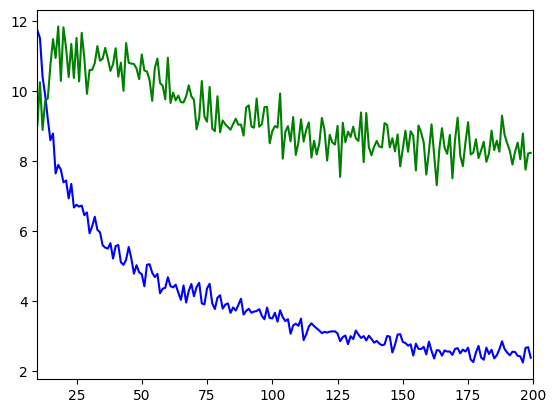

In [ ]:
loss_plot(model.train_loss[10:], model.valid_loss[10:], x_axis=[10, len(model.valid_loss)])